1D Wave equation:

\begin{align} u_{tt} \left( x,t \right) + c^2 u_{xx}\left( x,t \right)&=0, \\ \nonumber \\ u\left( x, 0 \right) &= u_0\left(x\right), \nonumber \\ \nonumber \\ x\in \left[ 0,1 \right),& \ t\in \left[0, 1 \right], \nonumber \end{align}

In [1]:
from solver.my_random_fields import GRF_Mattern
from solver.WaveEq import WaveEq1D
from train_utils.utils import load_config

import torch
import matplotlib.pyplot as plt

In [2]:
config_file = 'configs/wave-0000.yaml'
config = load_config(config_file)
display(config)

{'data': {'name': 'Wave-0000',
  'total_num': 1000,
  'n_train': 900,
  'n_test': 100,
  'nx': 4096,
  'nt': 100,
  'sub': 32,
  'sub_t': 1,
  'c': 1.0},
 'model': {'fno': {'in_channels': 1,
   'out_channels': 1,
   'decoder_layers': 1,
   'decoder_layer_size': 32,
   'dimension': 2,
   'latent_channels': 32,
   'num_fno_layers': 4,
   'num_fno_modes': 12,
   'padding': 9}},
 'train': {'batchsize': 20,
  'epochs': 500,
  'milestones': [150, 300, 450],
  'base_lr': 0.001,
  'scheduler_gamma': 0.5,
  'ic_loss': 5.0,
  'f_loss': 1.0,
  'xy_loss': 10.0,
  'save_dir': 'Wave',
  'save_name': 'Wave-eqn.pt',
  'ckpt': 'checkpoints/Wave/Wave-eqn.pt',
  'ckpt_freq': 100},
 'log': {'project': 'PINO-Wave', 'group': 'Wave-0000'},
 'test': {'batchsize': 1, 'ckpt': 'checkpoints/Wave/Wave-eqn.pt'}}

In [3]:
Nsamples = config['data']['total_num']
N = config['data']['nx']
Nt0 = config['data']['nt']
c = config['data']['c']
sub_x = config['data']['sub']
sub_t = config['data']['sub_t']
Nx = N // sub_x
Nt = Nt0 // sub_t + 1
dim = 2
l = 0.1
L = 1.0
sigma = 0.2 #2.0
Nu = None # 2.0
dt = 1.0e-4
tend = 1.0
save_int = int(tend/dt/Nt)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
grf = GRF_Mattern(dim, N, length=L, nu=Nu, l=l, sigma=sigma, boundary="periodic", device=device)
U0 = grf.sample(Nsamples)

In [ ]:
# Randomly generated wave forms at t = 0
# shape = (# of samples, # of spatial points)
U0.shape

torch.Size([1000, 4096])

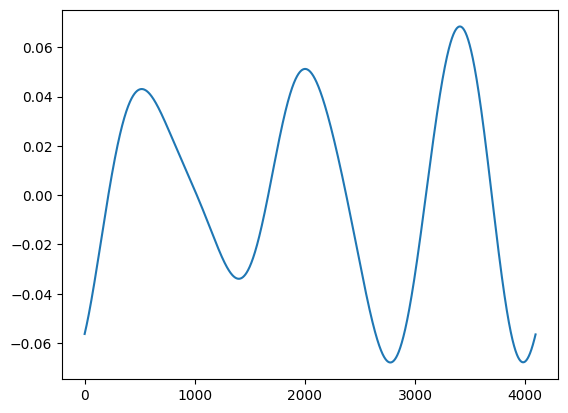

In [12]:
plt.plot(U0.cpu().numpy()[100])

In [ ]:
# Numerically solving 1D-wave
wave_eq = WaveEq1D(Nx=N, c=c, dt=dt, device=device)
U = torch.vmap(wave_eq.wave_driver, in_dims=(0, None))(U0, save_int)

In [ ]:
a = U0.cpu().float() # input initial states
u = U.cpu().float() # output final states (shape = (# of samples, # of time points, # of spatial points))

display(u.shape,a.shape)

torch.Size([1000, 102, 4096])

torch.Size([1000, 4096])

In [26]:
torch.save(u, "u.pt")
torch.save(a, "a.pt")

---
Set up PhysicsNeMo training 

In [15]:
a = torch.load("a.pt", map_location="cuda:0")
u = torch.load("u.pt", map_location="cuda:0")

In [16]:
X = a.unsqueeze(1).unsqueeze(2).expand(-1, -1, u.shape[1], -1)
X.shape

torch.Size([1000, 1, 102, 4096])

In [17]:
X[:1].shape

torch.Size([1, 1, 102, 4096])

In [18]:
Y = u.unsqueeze(1)
Y.shape

torch.Size([1000, 1, 102, 4096])

In [8]:
from physicsnemo.sym.eq.pdes.wave_equation import WaveEquation
from physicsnemo.models.fno import FNO
from physicsnemo.sym.eq.phy_informer import PhysicsInformer
from physicsnemo.launch.logging import LaunchLogger
import torch.nn.functional as F
import numpy as np
from train_utils.datasets import DataLoader1D


/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:91: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  _EPOCH_DATETIME_NAIVE = datetime.datetime.utcfromtimestamp(0)
/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
wave = WaveEquation(
    c=1.,
    dim=1
)

In [10]:
wave.equations["wave_equation"]

Derivative(u(x, t), (t, 2)) - 1.0*Derivative(u(x, t), (x, 2))

In [21]:
wave.pprint()

wave_equation: u__t__t - 1.0*u__x__x


In [9]:
dataset = DataLoader1D(a, u, config['data']['nx'], config['data']['nt'], config['data']['sub'], config['data']['sub_t'])
train_loader = dataset.make_loader(config['data']['n_train'], config['train']['batchsize'], start=0, train=True)
test_loader = dataset.make_loader(config['data']['n_test'], config['test']['batchsize'], start=config['data']['n_train'], train=False)

In [11]:
# Instantiate a Fourier Neural Operator (FNO) for 1D.
model = FNO(
    in_channels=config["model"]["fno"]["in_channels"],    # e.g., 1 for initial wave field
    out_channels=config["model"]["fno"]["out_channels"],  # e.g., 1 for predicted wave field
    decoder_layers=config["model"]["fno"]["decoder_layers"],
    decoder_layer_size=config["model"]["fno"]["decoder_layer_size"],
    dimension=config["model"]["fno"]["dimension"],                              # 1D problem
    latent_channels=config["model"]["fno"]["latent_channels"],
    num_fno_layers=config["model"]["fno"]["num_fno_layers"],
    num_fno_modes=config["model"]["fno"]["num_fno_modes"],
    padding=config["model"]["fno"]["padding"],
).to(device)

In [12]:
# Create a PhysicsInformer to enforce the 1D wave equation.
# It will compute the PDE residual using a finite-difference method.
phy_informer = PhysicsInformer(
    required_outputs=["wave_equation"],
    equations=wave,
    grad_method="finite_difference",
    device=device,
#    fd_dx=1 / cfg.dataset.spatial_resolution,  # e.g. resolution of the spatial grid
)

In [ ]:
phy_informer.required_inputs

['u', 'u__t__t']

In [19]:
pred = model(X[:4])

In [20]:
pred.shape

torch.Size([4, 1, 102, 4096])

In [ ]:
pred

In [12]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=config["train"]["base_lr"],
    betas=(0.9, 0.999),
    weight_decay=0.0,
)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=config["train"]["scheduler_gamma"])

In [13]:
def validation_step(model, dataloader, epoch):
    """Run validation and save comparison plots."""
    model.eval()
    with torch.no_grad():
        loss_epoch = 0.0
        for data in dataloader:
            invar, outvar, _, _ = data
            # For prediction, assume invar contains the initial condition in channel 0.
            pred = model(invar[:, 0].unsqueeze(dim=1))
            loss_epoch += F.mse_loss(outvar, pred)
        
        # Convert to numpy arrays for plotting (using the last batch)
        true_field = outvar.detach().cpu().numpy()
        pred_field = pred.detach().cpu().numpy()

        fig, ax = plt.subplots(1, 3, figsize=(25, 5))
        d_min = np.min(true_field[0, 0])
        d_max = np.max(true_field[0, 0])
        
        im0 = ax[0].imshow(true_field[0, 0], vmin=d_min, vmax=d_max)
        plt.colorbar(im0, ax=ax[0])
        im1 = ax[1].imshow(pred_field[0, 0], vmin=d_min, vmax=d_max)
        plt.colorbar(im1, ax=ax[1])
        im2 = ax[2].imshow(np.abs(true_field[0, 0] - pred_field[0, 0]))
        plt.colorbar(im2, ax=ax[2])
        
        ax[0].set_title("True")
        ax[1].set_title("Predicted")
        ax[2].set_title("Difference")
        
        fig.savefig(f"results_wave_epoch_{epoch}.png")
        plt.close()
        return loss_epoch / len(dataloader)

In [14]:
LaunchLogger.initialize()

In [ ]:
# Training loop
for epoch in range(config["train"]["epochs"]):
    with LaunchLogger(
        "train", epoch=epoch, num_mini_batch=len(train_loader), epoch_alert_freq=10
    ) as log:
        for data in train_loader:
            optimizer.zero_grad()
            invar = data[0]  # input: wave at t=0, shape [batch, channels, ...]
            outvar = data[1] # ground-truth wave field at later times

            # Forward pass: predict wave field at later times.
            # Here we assume the network input is the initial condition.
            pred = model(invar[:, 0].unsqueeze(dim=1))
            
            # Compute the physics-informed residual.
            # The physics informer will use finite differences on the predicted field
            # to evaluate the wave equation residual.
            residuals = phy_informer.forward({"u": pred})
            # Extract the residual associated with the wave equation.
            pde_residual = residuals["wave_equation"]
            # For 1D, pad along the spatial dimension if necessary.
            pde_residual = F.pad(pde_residual[:, :, 2:-2], [2, 2], "constant", 0)
            loss_pde = F.l1_loss(pde_residual, torch.zeros_like(pde_residual))
            
            # Compute data loss between predicted and true wave field.
            loss_data = F.mse_loss(outvar, pred)
            
            # Total loss: data loss plus a physics loss weighted by a factor.
            loss = loss_data + (1 / cfg.dataset.spatial_resolution) * cfg.physics_weight * loss_pde
            
            # Backpropagation and optimization step.
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            log.log_minibatch({
                "loss_data": loss_data.detach(),
                "loss_pde": loss_pde.detach()
            })
        log.log_epoch({"Learning Rate": optimizer.param_groups[0]["lr"]})

    # Run validation and log the error.
    with LaunchLogger("valid", epoch=epoch) as log:
        error = validation_step(model, val_loader, epoch)
        log.log_epoch({"Validation error": error})

    # Save a checkpoint at the end of each epoch.
    save_checkpoint(
        "./checkpoints",
        models=model,
        optimizer=optimizer,
        scheduler=scheduler,
        epoch=epoch,
    )